In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

### Merging ERA5 weather data with the penguin dataset

In [2]:
ERA5_FILES = '../data/era5/*.nc'
PENGUIN_DATASET = '../data/penguin/penguins_final.csv'

era5 = xr.open_mfdataset(ERA5_FILES, combine='by_coords')
penguin_df = pd.read_csv(PENGUIN_DATASET)

In [3]:
era5

<xarray.Dataset> Size: 2GB
Dimensions:     (latitude: 97, longitude: 301, valid_time: 2200)
Coordinates:
  * latitude    (latitude) float64 776B -38.0 -38.5 -39.0 ... -85.0 -85.5 -86.0
  * longitude   (longitude) float64 2kB -162.0 -161.5 -161.0 ... -12.5 -12.0
  * valid_time  (valid_time) datetime64[ns] 18kB 1996-10-30 ... 2017-02-14
    number      int64 8B 0
Data variables:
    avg_smr     (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
    rsn         (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
    sd          (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
    siconc      (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 257MB dask.array<chunksize=(733, 33, 101), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-24T13:19 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
penguin_df['date_gmt'] = pd.to_datetime(penguin_df['date_gmt'])

'''
Create columns:
 - t2m: 2m temperature
 - tp: Total precipitation 
 - sst: Sea surface temperature
 - siconc: Sea ice concentration
 - sd: Snow depth
 - rsn: Snow density
 - avg_smr: Average snowfall 
'''
penguin_df['t2m'] = np.nan
penguin_df['tp'] = np.nan
penguin_df['sst'] = np.nan
penguin_df['siconc'] = np.nan
penguin_df['sd'] = np.nan
penguin_df['rsn'] = np.nan
penguin_df['avg_smr'] = np.nan


# Prepare target points for interpolation
target_lats = xr.DataArray(penguin_df['latitude_mean'].values, dims="points")
target_lons = xr.DataArray(penguin_df['longitude_mean'].values, dims="points")
target_times = xr.DataArray(penguin_df['date_gmt'].values, dims="points")

# Interpolate for all points at once
interpolated = era5.interp(latitude=target_lats, longitude=target_lons, valid_time=target_times)

'''
Assigning interpolated values to the penguin dataframe

Remark 1: Temperature is converted from Kelvin to Celsius (therefore -273)
Remark 2: Dataset contains means for 1 hour time intervals, therefore tp & avg_smr are multiplied by 24 to get daily values
'''
penguin_df['tp'] = interpolated['tp'].values * 24 
penguin_df['t2m'] = interpolated['t2m'].values - 273 
penguin_df['sst'] = interpolated['sst'].values - 273
penguin_df['siconc'] = interpolated['siconc'].values
penguin_df['sd'] = interpolated['sd'].values
penguin_df['rsn'] = interpolated['rsn'].values
penguin_df['avg_smr'] = interpolated['avg_smr'].values * 24


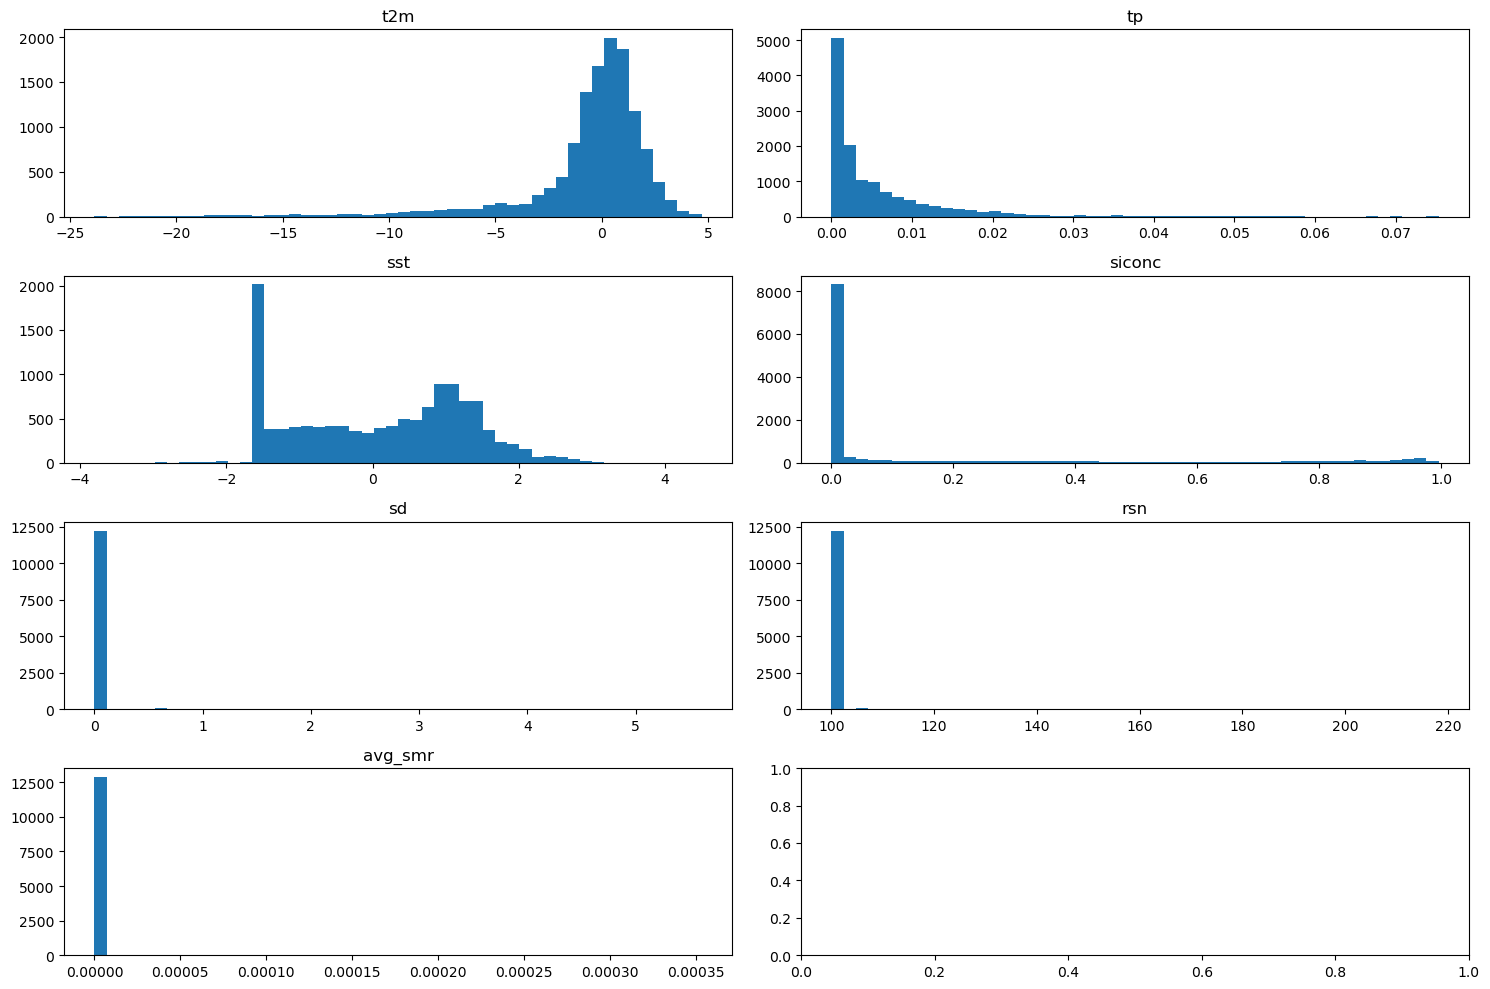

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(['t2m', 'tp', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']):
    axs[i].hist(penguin_df[col], bins=50)
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()


In [6]:
# save the data
penguin_df.to_csv('../data/penguin/penguins_final_with_era5.csv', index=False)

In [13]:
penguin_df.lat_colony_mean

date_gmt
2016-11-10   -62.03
2016-11-11   -62.03
2016-11-19   -62.03
2016-11-20   -62.03
2017-02-06   -62.03
              ...  
2010-02-12   -62.47
2010-02-13   -62.47
2010-02-14   -62.47
2009-01-12   -62.47
2009-01-13   -62.47
Name: lat_colony_mean, Length: 13226, dtype: float64

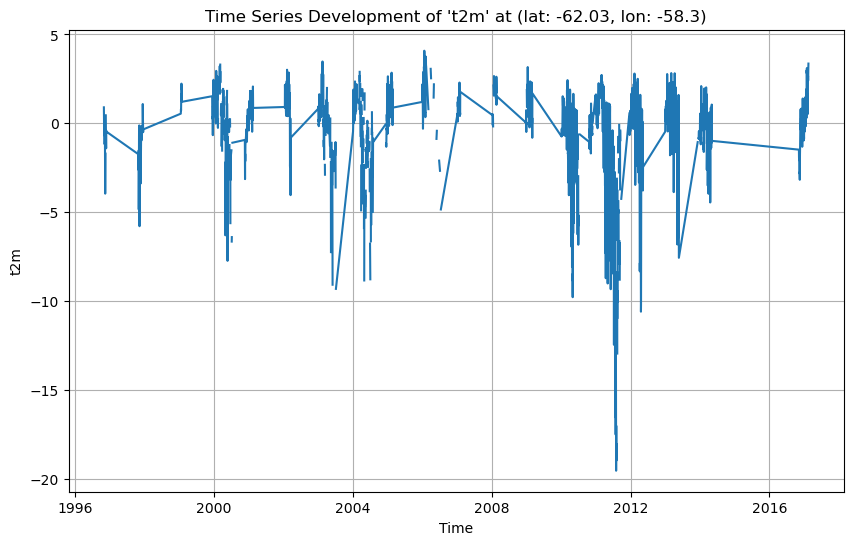

In [17]:
lat = -62.03 # Replace with the specific latitude
lon = -58.3  # Replace with the specific longitude

# Extract the time series for the 't2m' variable at the specified coordinates
t2m_time_series = era5['t2m'].sel(latitude=lat, longitude=lon, method='nearest')
t2m_time_series = t2m_time_series - 273.15  # Convert from Kelvin to Celsius

# Plot the time series
plt.figure(figsize=(10, 6))
t2m_time_series.plot()
plt.title(f"Time Series Development of 't2m' at (lat: {lat}, lon: {lon})")
plt.xlabel('Time')
plt.ylabel('t2m')
plt.grid(True)
plt.show()